# Using QSVT for fixed-point amplitude amplification

This demo will show how to use the QSVT framework for search problems. Specifically, we will implement fixed-point amplitude amplification (FPAA). In FPAA, we do not know in advance the concentration of solutions to the search problem, want to sample a solution with high probability. In contrast, for the original grover search algorithm, too much iterations might 'overshoot'.

The demo is based on the paper [Grand unification of quantum algorithms](#grand).

Given $|s\rangle$ the initial state and $|t\rangle$ the 'good' states, we get an effective block encoding of a 1-dimensional matrix $A=|t\rangle\langle s|$.

Given that  $a = \langle s|t\rangle\gt0$, we want to amplify $a$. The signal operator $U$ here will be $I$ (and also $\dagger{U}$). Now we implement 2 projector-rotations - one in '$|s\rangle$' space and one in '$|t\rangle$' space, each one around the given state, giving phase to the specific state.

### Defining the QSVT circuit for the problem

We start with the general qsvt framework definition. It accepts a unitary which block-encode a matrix together with projector-controlled-phase functions which rotate the state around each of the subspaces where the matrix is encoded.

It applies the `qsvt_step` multiple times, iterating over the rotation angles provided which encode the polynomial transformation.
Notice - The last step is quite tricky and depend on the specific transformation we wish to perform. Here the code is suitable for the FP Amplitude Amplification case. Also - we wrap the auxilliary qubit with $H$ gates.

In [1]:
from typing import List

from classiq import QArray, QBit, QNum, qfunc
from classiq.qmod import (
    IDENTITY,
    RZ,
    H,
    QCallable,
    QParam,
    X,
    allocate,
    apply_to_all,
    control,
    hadamard_transform,
    if_,
    invert,
    repeat,
)
from classiq.qmod.symbolic import logical_and


@qfunc
def qsvt_step(
    phase_seq: QParam[List[float]],
    index: QParam[int],
    proj_ctrl_phase_1: QCallable[QParam[float], QArray[QBit], QBit],
    proj_ctrl_phase_2: QCallable[QParam[float], QArray[QBit], QBit],
    u: QCallable[QArray[QBit]],
    qbv_reg: QArray[QBit],
    qbv_aux: QBit,
):
    proj_ctrl_phase_1(phase_seq[2 * index], qbv_reg, qbv_aux)
    u(qbv_reg)
    proj_ctrl_phase_2(phase_seq[2 * index + 1], qbv_reg, qbv_aux)

    if_(
        condition="2 * index +  2 == len(phase_seq)",
        then=lambda: IDENTITY(qbv_reg),
        else_=lambda: invert(lambda: u(qbv_reg)),
    )


@qfunc
def qsvt(
    phase_seq: QParam[List[float]],
    proj_ctrl_phase_1: QCallable[QParam[float], QArray[QBit], QBit],
    proj_ctrl_phase_2: QCallable[QParam[float], QArray[QBit], QBit],
    u: QCallable[QArray[QBit]],
    qbv_reg: QArray[QBit],
    qbv_aux: QBit,
) -> None:
    H(qbv_aux)

    repeat(
        count="len(phase_seq) / 2",
        iteration=lambda index: qsvt_step(
            phase_seq, index, proj_ctrl_phase_1, proj_ctrl_phase_2, u, qbv_reg, qbv_aux
        ),
    )

    H(qbv_aux)

## Initial state z-rotation - rotation around $|s\rangle$

In [2]:
def initial_state_rot(phase: QParam[float], state: QArray[QBit], aux: QBit):
    hadamard_transform(state)
    apply_to_all(X, state)
    control(operand=lambda: X(aux), ctrl=state)
    RZ(phase, aux)
    control(operand=lambda: X(aux), ctrl=state)
    apply_to_all(X, state)
    hadamard_transform(state)

## Good states z-rotation - rotation around $|t\rangle$

In [3]:
def target_state_rot(
    phase: QParam[float],
    arith_oracle: QCallable[QArray[QBit], QBit],
    state: QArray[QBit],
    aux: QBit,
):
    arith_oracle(state, aux)
    RZ(phase, aux)
    arith_oracle(state, aux)

## Defining the arithmetic Oracle

In [4]:
EQUATION = "(a + b) == 3 and (c - a) == 2"

REG_SIZES = {"a": 2, "b": 1, "c": 3}
REG_SIZE = sum(REG_SIZES.values())


@qfunc
def arith_equation(a: QNum, b: QNum, c: QNum, res: QBit):
    res ^= logical_and((a + b) == 3, (c - a) == 2)

## Wrapping everything together for the FPAA case

In the FPAA case, the provided unitary is just the Identity matrix! In addition, we provide both projector-controlled phase functions - the initial and target state rotations.

In [5]:
from classiq.qmod import Output


@qfunc
def qsvt_fpaa(
    phase_seq: QParam[List[float]],
    arith_oracle: QCallable[QArray[QBit], QBit],
    qbv_reg: QArray[QBit],
    qbv_aux: Output[QBit],
) -> None:
    allocate(1, qbv_aux)

    qsvt(
        phase_seq,
        lambda phase, state, aux: initial_state_rot(phase, state, aux),
        lambda phase, state, aux: target_state_rot(phase, arith_oracle, state, aux),
        lambda state: IDENTITY(target=state),
        qbv_reg,
        qbv_aux,
    )

## get the phase sequence for the sign function

Now we will use the package `pyqsp` in order to get the phases of the rotation sequence.
Get directly the coef of the sign function, based on the erfc approximation.

In [6]:
import pyqsp

DEGREE = 25
X_BASIS = True

pg = pyqsp.poly.PolySign()
pcoefs, scale = pg.generate(
    degree=DEGREE, delta=10, ensure_bounded=True, return_scale=True
)

[pyqsp.poly.PolySign] degree=25, delta=10
[PolyTaylorSeries] max [0.89999873] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.0962788793562509 in the domain [-1, 1] using degree 25


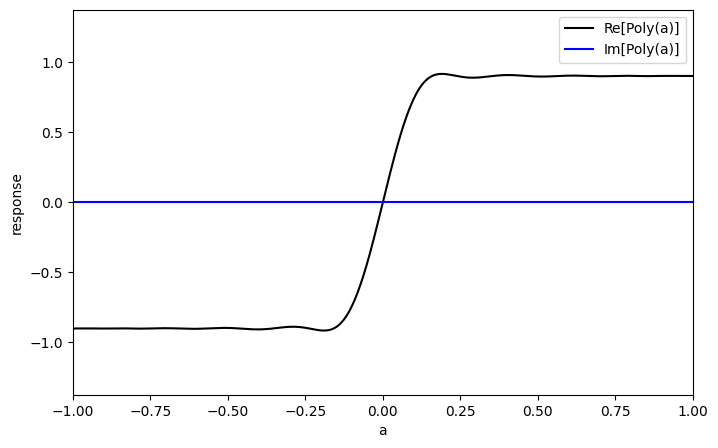

In [7]:
import numpy as np
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

poly = Polynomial(pcoefs)
measurement = "x"
ang_seq = QuantumSignalProcessingPhases(
    poly, signal_operator="Wx", method="laurent", measurement=measurement
)
pyqsp.response.PlotQSPResponse(ang_seq, signal_operator="Wx", measurement=measurement)

As $R(a)=-i*e^{i\frac{\pi}{4}Z}W(a)e^{i\frac{\pi}{4}Z}$ and we have odd number of rotations, we get an $i$ phase to our polynomial, so we get $Im(P(a))$ instead of the real part. So we will get the result in the $|1\rangle$ state in the ancilla. However, we can fix it by adding $\pi/2$ phase to the last or first rotation.

In [8]:
#### change the R(x) to W(x), as the phases are in the W(x) conventions
phases = np.array(ang_seq)
phases = phases - np.pi / 2
phases[0] = phases[0] + np.pi / 4
phases[-1] = phases[-1] + np.pi / 4 + np.pi / 2

phases = (
    -2 * phases
)  # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp

## Create the full QSVT Model

In [9]:
from classiq import Constraints, create_model, synthesize
from classiq.builtin_functions import HGate, Identity


@qfunc
def main(state: Output[QArray[QBit]], aux: Output[QBit]):
    allocate(REG_SIZE, state)

    hadamard_transform(state)
    qsvt_fpaa(
        phase_seq=list(phases),
        arith_oracle=lambda state_reg, aux_reg: arith_equation(
            state_reg[0 : REG_SIZES["a"]],
            state_reg[REG_SIZES["a"] : REG_SIZES["a"] + REG_SIZES["b"]],
            state_reg[REG_SIZES["a"] + REG_SIZES["b"] : REG_SIZE],
            aux_reg,
        ),
        qbv_reg=state,
        qbv_aux=aux,
    )

## Synthesis and execution on a simulator

We will use classiq's synthesis engine to translate the model to a quantum circuit, and execute on the `aer_simulator`

In [10]:
from classiq import (
    create_model,
    execute,
    set_execution_preferences,
    show,
    synthesize,
    write_qmod,
)
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

# convert the functions to a qmod model
constraints = Constraints(max_width=12)
qmod = create_model(main, constraints)

NUM_SHOTS = 1000
# we will want to execute this qmod on a state-vector simulator:
execution_preferences = ExecutionPreferences(
    num_shots=NUM_SHOTS,
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator"),
)
qmod = set_execution_preferences(qmod, execution_preferences)

write_qmod(qmod, "qsvt_fixed_point_amplitude_amplification")

In [11]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/153a2a95-b762-4668-8eee-8e33ef5cb7f7?version=0.38.0.dev42%2Bfd36e2c41c


Execute the circuit:

In [12]:
from classiq.execution import ExecutionDetails

raw_results = execute(qprog).result()
results = raw_results[0].value

In [13]:
def to_int(x):
    return int(x[::-1], 2)


def equation(a, b, c):
    return eval(EQUATION)


measured_good_shots = 0

for keys, counts in results.counts_of_multiple_outputs(["state", "aux"]).items():
    a, b, c, aux = (
        to_int(keys[0][: REG_SIZES["a"]]),
        to_int(keys[0][REG_SIZES["a"] : REG_SIZES["a"] + REG_SIZES["b"]]),
        to_int(keys[0][-REG_SIZES["c"] :]),
        to_int(keys[1]),
    )
    if equation(a, b, c) and (aux == 0):
        print(
            f"a: {a}, b: {b}, c: {c}, aux: {aux}, equation_result: {equation(a, b, c)}, counts={counts}"
        )
        measured_good_shots += counts

print("Measured good shots:", measured_good_shots)

a: 3, b: 0, c: 5, aux: 0, equation_result: True, counts=420
a: 2, b: 1, c: 4, aux: 0, equation_result: True, counts=399
Measured good shots: 819


What do we expect?

We need to subtitue the amplitude of $|s\rangle\langle t|$ in $P(x)$:

In [14]:
p_good_shot = poly(np.sqrt(2 / 2**6)) ** 2
print("Expected good shots:", NUM_SHOTS * p_good_shot)

Expected good shots: 832.9873728406709


Indeed, we got the expected result according to the polynomial we created with the QSVT sequence.

In [15]:
import scipy

assert np.isclose(
    measured_good_shots,
    NUM_SHOTS * p_good_shot,
    atol=5 * scipy.stats.binom.std(NUM_SHOTS, p_good_shot),
)

## References

<a id='grand'>[1]</a>: [Martyn JM, Rossi ZM, Tan AK, Chuang IL. Grand unification of quantum algorithms. PRX Quantum. 2021 Dec 3;2(4):040203.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203)
